# Read the cleaned data set

In [180]:
# magic commands to make sure external modules are reloaded every complete run
%load_ext autoreload
%autoreload 2

import pandas as pd

# read the merged dataframe
master = pd.read_excel("../data/processed/complete_env_taxa_chemical.xlsx", 
                      sheet_name="all_data_merged", 
                      header=[0, 1, 2], 
                      index_col=0)

master.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


block     sample_info                           environmental            \
subblock          raw                                     raw             
var          Latitude Longitude Waterbody  Year       LOI (%) MPS (Phi)   
StationID                                                                 
A10          42.90455 -82.46760       SCR  2004      3.436193  1.734259   
A23          42.56658 -82.57595       LSC  2004      3.226637  1.969984   
A27          42.56007 -82.42132       LSC  2004      2.802642  1.319519   
A28          42.54577 -82.42073       LSC  2004      3.201399  1.398687   
A29          42.51440 -82.43462       LSC  2004      6.180718  1.065748   

block                                                                      \
subblock                                                                    
var       Measured Depth (m) Temperature (oC) Velocity  at bottom (m/sec)   
StationID                                                                   
A10                      1.8            19.17                         NaN   
A23                      3.0            19.10                         NaN   
A27                      1.0            18.40                         NaN   
A28                      0.5            18.90                         NaN   
A29                      0.5            19.30                         NaN   

block                             ...           taxa                          \
subblock                          ...            raw                           
var       Water DO Bottom (mg/L)  ... Hydropsychidae      Hydrozoa  Nematoda   
StationID                         ...                                          
A10                        10.21  ...   3.203427e-16  3.203427e-16  1.727234   
A23                        10.09  ...   3.203427e-16  3.203427e-16  2.427993   
A27                        10.30  ...   3.203427e-16  3.203427e-16  1.802219   
A28                        12.80  ...   3.203427e-16  3.203427e-16  2.771800   
A29                         9.70  ...   3.203427e-16  3.203427e-16  4.616441   

block                                                                \
subblock                                                              
var       Oligochaeta Other Trichoptera   Sphaeriidae   Turbellaria   
StationID                                                             
A10          6.576942      3.203427e-16  3.203427e-16  3.203427e-16   
A23          5.872905      3.203427e-16  1.022139e+00  5.997595e-01   
A27          6.402280      1.580169e+00  1.317615e+00  9.964067e-01   
A28          5.867874      2.049287e+00  2.863547e+00  3.203427e-16   
A29          5.181664      3.203427e-16  3.203427e-16  3.203427e-16   

block     2008_results                          
subblock   DR_clusters       corridor_clusters  
var         DR_cluster if_RF  corridor_cluster  
StationID                                       
A10                  0     0                 1  
A23                  0     0                 1  
A27                  0     0                 1  
A28                  0     0                 1  
A29                  0     0                 1  

[5 rows x 59 columns]

# Set the weight mapping objectively(test purpose) for all stressors

There are two common ways to set weights for stressors:
1. Group the stressors into categories, and set weights for each category.
    - The stressors can be categorized into groups, like earth elements, toxic metals and so on. 
     Such grouping can help set same weights for stressors in the same group, but gives less flexibility.
2. Set weights for each stressor individually.
    - This way gives more flexibility to set weights for each stressor, but takes more effort to decide the weights.


## Categorize the stressors and set weights for each category

In [181]:
from ecoindex.dataframe_ops import get_block # function to fetch the wanted block from the wrapped dataframe

# import the chemical weights configuration
from ecoindex.chemical_weights import (
    build_weights_for_columns, # function to build weight mapping for variables
    VARIABLE_TYPE_BY_NAME, # default category mapping for: variable name -> variable type
)

# Columns in use for the PCA call above
chem_cols = get_block(master, "chemical", "raw").columns

# specify custom weights for certain types (others will use defaults)
std_weight = 1.0

type_weights = {
    "Trace Metal (pollutant)": std_weight,
    "Hydrocarbon pollutant": std_weight,        # Highest priority: petroleum/chlorobenzenes
    "organochlorine pesticide": std_weight,     # Highest priority: POPs
    "Sum of all PCBs": 3 * std_weight,              # Highest priority: PCBs
    "Binding agent": std_weight,               # Medium priority: affects bioavailability
    "Earth element (nontoxic)": std_weight   # Lowest priority: background elements
}

# Build the final weight map for the variables for later use in weighted PCA
custom_weight_map = build_weights_for_columns(chem_cols,
                                              variable_type_by_name =VARIABLE_TYPE_BY_NAME,
                                              type_weights=type_weights,
                                              weights_by_name={"Sb": 1.0} # set a subtle weight for Sb specifically
                                             )

In [182]:
# Create a DataFrame to visualize the weight assignments
weight_analysis = []
for var in chem_cols:
    var_type = VARIABLE_TYPE_BY_NAME.get(var, "Unclassified")
    weight = custom_weight_map.get(var, 1.0)
    weight_analysis.append({
        'Variable': var,
        'Type': var_type,
        'Weight': weight
    })

weight_df = pd.DataFrame(weight_analysis)

# Group by type and show weight distribution
print("Weight Distribution by Variable Type:")
print("=" * 40)
weight_summary = weight_df.groupby(['Type', 'Weight']).size().reset_index(name='Count')
for _, row in weight_summary.iterrows():
    print(f"{row['Type']}: Weight {row['Weight']} ({row['Count']} variables)")

print(f"\nTotal variables: {len(weight_df)}")
print(f"Unique weights: {sorted(weight_df['Weight'].unique())}")

# Show variables with highest weights
print(f"\nHighest weighted variables (weight > {std_weight}):")
high_weight = weight_df[weight_df['Weight'] > std_weight].sort_values('Weight', ascending=False)
print(high_weight.to_string(index=False))


Weight Distribution by Variable Type:
Binding agent: Weight 1.0 (1 variables)
Earth element (nontoxic): Weight 1.0 (6 variables)
Hydrocarbon pollutant: Weight 1.0 (5 variables)
Sum of all PCBs: Weight 3.0 (1 variables)
Trace Metal (pollutant): Weight 1.0 (13 variables)
organochlorine pesticide: Weight 1.0 (4 variables)

Total variables: 30
Unique weights: [np.float64(1.0), np.float64(3.0)]

Highest weighted variables (weight > 1.0):
 Variable            Type  Weight
total PCB Sum of all PCBs     3.0


# Apply PCA with the customed weights

Set the weight mapping to the designed `pca_chemical_assessment` function, make sure to standardize the variables to make the
weights most effective.

In [183]:
from ecoindex import pca_assessment
# Run PCA with weights applied
result_weighted = pca_assessment.pca_chemical_assessment(
    master,
    chemical_block="chemical",
    subblock="raw",
    standardize=True,
    apply_weights=True,
    custom_weights=custom_weight_map,
)

result_weighted.loadings.head()

Applied variable weights:
[3.0, -): 1 vars, 
[2.0, 3.0): 0 vars, 
[1.0, 2.0): 0 vars, 
=1.0: 29 vars


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
var,,,,,,,,,,,,,,,,,,,,,
%OC,0.223960,-0.149455,-0.027807,0.120147,-0.035649,0.043588,-0.032313,-0.048060,0.254182,0.063464,...,-0.037534,0.175697,0.093458,0.055116,0.026759,-0.011596,-0.009305,-0.066859,0.023214,-0.040704
1234-TCB,0.043959,-0.012179,-0.016411,0.050362,-0.045946,0.608548,-0.509972,0.119541,0.348400,-0.249622,...,0.042174,-0.001788,-0.084328,-0.032743,-0.022940,0.004013,0.009308,-0.000998,0.009721,0.012154
1245-TCB,0.051872,-0.086933,0.420424,-0.050654,0.029465,-0.281692,0.066947,0.007251,0.356958,-0.268466,...,-0.075995,-0.051162,-0.033645,-0.045513,0.057082,-0.121314,0.055826,0.016839,-0.026334,0.013460
Al,0.216234,-0.219417,-0.141562,0.030208,0.091682,0.035903,0.206044,-0.184706,0.059344,-0.090866,...,-0.018799,0.038530,-0.292170,-0.032345,-0.218289,0.042701,0.301656,-0.086732,0.577157,0.383938
As,0.137688,-0.084567,-0.145114,-0.076896,0.101708,-0.317039,-0.111648,0.538803,0.170327,0.383549,...,-0.090865,0.022714,-0.188539,0.006264,-0.105534,0.010985,0.062366,-0.003509,-0.019864,-0.028767


## Filter PCs by considering ratios of high-weighted variables over high-loading variables

In [184]:
# Select PCs dominated by high-weight variables
from ecoindex import pca_assessment

selection_pos = pca_assessment.select_pcs_by_weighted_loadings(
    result_weighted,
    high_weight_threshold=1,
    loading_threshold=0.2,
    top_k_variables_per_pc=10,
    prefer_positive=True,
)

filtered_pcs = selection_pos["selected_pcs"]
print(f"Total explained variance: {selection_pos['cumulative_explained_variance']}")
filtered_pcs

Total explained variance: 0.9538737437817735


['PC1',
 'PC2',
 'PC3',
 'PC4',
 'PC5',
 'PC6',
 'PC8',
 'PC9',
 'PC10',
 'PC11',
 'PC13',
 'PC14',
 'PC15',
 'PC16',
 'PC17',
 'PC18',
 'PC19',
 'PC21',
 'PC22',
 'PC23',
 'PC24',
 'PC25',
 'PC26',
 'PC27',
 'PC28']

## Compute pollution scores with selected PCs

In [185]:
from ecoindex.pca_assessment import compute_pollution_scores_with_labels
from ecoindex.dataframe_ops import merge_into_master_by_station

# Compute tidy pollution scores and labels from selected PCs
pollution_scores_df = compute_pollution_scores_with_labels(
    result_weighted,
    filtered_pcs,
    quantiles=(0.2, 0.8),
)

# Merge into the master as a new block/subblock
master = merge_into_master_by_station(
    master,
    pollution_scores_df,
    block_name="pollution",
    subblock_name="sumreal_by_logz_chemical",
)

# Display the new pollution block
pollution_block = master[("pollution", "sumreal_by_logz_chemical")]
pollution_block

/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_45778/2212475230.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  pollution_block = master[("pollution", "sumreal_by_logz_chemical")]


var,SumReal,Quality
StationID,,
A10,1.705548,medium
A23,0.012639,medium
A27,-1.095659,medium
A28,-1.910652,medium
A29,5.746271,degraded
...,...,...
S99,-1.877233,medium
UBC1,-0.776593,medium
UCC1,-0.825001,medium


## Create a shuffled SumReal and Quality for comparison

In [186]:
import numpy as np

# Set random seed for reproducibility (optional)
np.random.seed(42)

# Get the Quality column
quality_column = master[('pollution', 'sumreal_by_logz_chemical', 'Quality')]

# Get the SumReal column
sumreal_column = master[('pollution', 'sumreal_by_logz_chemical', 'SumReal')]

# Shuffle the values
shuffled_quality = quality_column.values.copy()
shuffled_sumreal = sumreal_column.values.copy()
np.random.shuffle(shuffled_sumreal) # type: ignore
np.random.shuffle(shuffled_quality) # type: ignore

# Update the Quality column in place
master[('pollution', 'sumreal_by_logz_chemical', 'SumReal_Shuffled')] = shuffled_sumreal
master[('pollution', 'sumreal_by_logz_chemical', 'Quality_Shuffled')] = shuffled_quality

# check it 
master[('pollution', 'sumreal_by_logz_chemical')].head()

/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_45778/3575041487.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
  master[('pollution', 'sumreal_by_logz_chemical')].head()


var,SumReal,Quality,SumReal_Shuffled,Quality_Shuffled
StationID,,,,
A10,1.705548,medium,-1.809620,reference
A23,0.012639,medium,0.283741,degraded
A27,-1.095659,medium,-3.735564,medium
A28,-1.910652,medium,3.250964,degraded
A29,5.746271,degraded,-3.097869,medium


## Add the 2006 original pollution ranks for comparison

In [187]:
# read and wrap the 2006 original pollution ranks into the master for comparison
original_rank = pd.read_excel("/Users/gufeng/Downloads/site_rank_test.xlsx")
original_rank.columns = ["StationID", "Rank"]
original_rank.head(10)

original_rank = original_rank.sort_values(by="Rank")
original_rank['SumReal'] = range(1, len(original_rank) + 1)
original_rank['Quality'] = original_rank.apply(lambda x: 'reference' if x['SumReal'] <= 20 else ('medium' if x['SumReal'] <= 80 else 'degraded'), axis=1)

# merge the original rank into the master_with_pollution dataframe
master = merge_into_master_by_station(
    master,
    original_rank.set_index("StationID"),
    block_name="pollution",
    subblock_name="2006_rank"
)

# Fill NaN values in the Quality column with "medium"
master[('pollution', '2006_rank', 'Quality')] = master[('pollution', '2006_rank', 'Quality')].fillna("medium")

master[('pollution', '2006_rank')].head()

/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_45778/655592079.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  master[('pollution', '2006_rank')].head()


var,Rank,SumReal,Quality
StationID,,,
A10,54.0,14.0,reference
A23,79.0,38.0,medium
A27,93.0,73.0,medium
A28,92.0,69.0,medium
A29,99.0,93.0,degraded


In [188]:
# groupby mean aggregation to check chemical concentrations means by pollution quality 
def groupby_aggregation(df, groupby_block, groupby_subblock, groupby_var, 
                       agg_block, agg_subblock, agg_functions='mean'):
    """
    Perform groupby aggregation on a multi-level column DataFrame.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The master dataframe with multi-level column structure (block, subblock, var)
    groupby_block : str
        Name of the block containing the groupby variable
    groupby_subblock : str
        Name of the subblock containing the groupby variable
    groupby_var : str
        Name of the variable to group by
    agg_block : str
        Name of the block to aggregate
    agg_subblock : str
        Name of the subblock to aggregate
    agg_functions : str or dict, default 'mean'
        Aggregation function(s) to apply. Can be:
        - String: single function like 'mean', 'sum', 'count', 'std'
        - Dict: mapping of column names to functions
        
    Returns:
    --------
    pandas.DataFrame : Aggregated results with groupby variable as index
    """
    # Extract the groupby column
    groupby_column = df[(groupby_block, groupby_subblock, groupby_var)]
    
    # Extract the block to aggregate
    agg_data = df[(agg_block, agg_subblock)]

    # Perform groupby aggregation
    if isinstance(agg_functions, str):
        # Single aggregation function
        result = agg_data.groupby(groupby_column).agg(agg_functions)
    else:
        # Multiple aggregation functions
        result = agg_data.groupby(groupby_column).agg(agg_functions)
    
    # Set index name
    result.index.name = f"{groupby_block}_{groupby_subblock}_{groupby_var}"
    
    return result

In [189]:
# Example usage of the groupby mean aggregation function: Group by pollution quality and aggregate chemical data
chemical_by_quality = groupby_aggregation(
    master,
    groupby_block="pollution",
    groupby_subblock="2006_rank", 
    groupby_var="Quality",
    agg_block="chemical",
    agg_subblock="raw",
    agg_functions="mean"
)

# print("Chemical concentrations by pollution quality:")
chemical_by_quality_transposed = chemical_by_quality.T.round(3)

chemical_by_quality_transposed

/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_45778/2951781373.py:34: PerformanceWarning: indexing past lexsort depth may impact performance.
  agg_data = df[(agg_block, agg_subblock)]


pollution_2006_rank_Quality,degraded,medium,reference
var,,,
%OC,3.197,2.151,1.385
1234-TCB,0.208,0.264,0.207
1245-TCB,2.617,0.715,0.275
Al,9611.150,4856.500,3126.150
As,2.096,1.856,2.216
Bi,18.919,17.118,16.907
Ca,37511.650,32392.500,20900.700
Cd,0.523,0.411,0.145
Co,6.162,4.029,3.209


In [190]:
master["pollution"]

subblock  sumreal_by_logz_chemical                             \
var                        SumReal   Quality SumReal_Shuffled   
StationID                                                       
A10                       1.705548    medium        -1.809620   
A23                       0.012639    medium         0.283741   
A27                      -1.095659    medium        -3.735564   
A28                      -1.910652    medium         3.250964   
A29                       5.746271  degraded        -3.097869   
...                            ...       ...              ...   
S99                      -1.877233    medium         0.025806   
UBC1                     -0.776593    medium        -4.941087   
UCC1                     -0.825001    medium         8.419834   
UCE1                     -1.799921    medium        -2.090481   
UJC1                      4.076629  degraded        -1.799921   

subblock                   2006_rank                     
var       Quality_Shuffled      Rank SumReal    Quality  
StationID                                                
A10              reference      54.0    14.0  reference  
A23               degraded      79.0    38.0     medium  
A27                 medium      93.0    73.0     medium  
A28               degraded      92.0    69.0     medium  
A29                 medium      99.0    93.0   degraded  
...                    ...       ...     ...        ...  
S99                 medium      67.0    23.0     medium  
UBC1                medium      98.0    91.0   degraded  
UCC1                medium      94.0    77.0     medium  
UCE1                medium      85.0    54.0     medium  
UJC1                medium     100.0    99.0   degraded  

[104 rows x 7 columns]

# Assessment of the pollution scores - PERMANOVA tests

## Create tested features and group labels

In [191]:
from ecoindex import (
    prepare_feature_matrix,
    build_groups_from_labels,
    build_groups_from_quantiles,
    run_assessment_suite,
    plot_permanova_null_distribution,
    plot_directional_null_distribution,
)

# prepare feature matrix
feat_block, feat_sub = 'chemical', 'raw'
X, idx = prepare_feature_matrix(master, 
                                    block=feat_block, 
                                    subblock=feat_sub, 
                                    variables=None, 
                                    standardize=True)
# specific feature names
var_names = list(master[(feat_block, feat_sub)].columns)

# prepare group labels based on pollution quality
labels = build_groups_from_labels(master,
                                      pollution_block='pollution', 
                                      pollution_subblock='sumreal_by_logz_chemical', 
                                      label_var='Quality').reindex(idx).values

# check the features and labels
print('X shape:', X.shape, '| labels:', len(labels))

X shape: (104, 30) | labels: 104


/Users/gufeng/2025_winter/Thesis_Project/ThesisProject/Project_Code/src/ecoindex/pca_evaluation.py:122: PerformanceWarning: indexing past lexsort depth may impact performance.
  sub = master[(block, subblock)]
/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_45778/2748965571.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  var_names = list(master[(feat_block, feat_sub)].columns)


### Generate test summary table
Use `run_assessment_suite` with features and labels to compute 5 results and display a compact table.

In [192]:
suite = run_assessment_suite(X, labels)

In [193]:
# Reorganize suite results into a cleaner dataframe
results = []

# PERMANOVA results
perm = suite['perm_direct']
results.append({
    'Test': 'PERMANOVA',
    'Statistic': perm['F'],
    'p_value': perm['p'],
    'R_squared': perm['R2'],
    'df_between': perm['df_between'],
    'df_within': perm['df_within'],
    'n_permutations': perm['n_perm'],
    'Additional_Info': f"Method: {perm['method']}"
})

# Directional Average results
dir_avg = suite['dir_avg']
results.append({
    'Test': 'Directional (Average)',
    'Statistic': dir_avg['stat'],
    'p_value': dir_avg['p'],
    'R_squared': None,
    'df_between': None,
    'df_within': None,
    'n_permutations': dir_avg['n_perm'],
    'Additional_Info': f"Mode: {dir_avg['mode']}, Ref: {dir_avg['reference_label']}, Deg: {dir_avg['degraded_label']}"
})

# Directional Minimum results
dir_min = suite['dir_min']
results.append({
    'Test': 'Directional (Minimum)',
    'Statistic': dir_min['stat'],
    'p_value': dir_min['p'],
    'R_squared': None,
    'df_between': None,
    'df_within': None,
    'n_permutations': dir_min['n_perm'],
    'Additional_Info': f"Mode: {dir_min['mode']}, Ref: {dir_min['reference_label']}, Deg: {dir_min['degraded_label']}"
})

# Create comprehensive results dataframe
results_df = pd.DataFrame(results)

# Add summary statistics
summary_stats = pd.DataFrame({
    'Metric': ['Null Tail p-value', 'Loss Function'],
    'Value': [suite['perm_null_tail']['p_tail'], suite['loss']],
    'Description': ['One-tailed permutation test p-value', 'Classification loss metric']
})

print("Assessment Suite Results:")
print("=" * 50)
print(results_df.to_string(index=False))
print("\nAdditional Metrics:")
print("=" * 20)
print(summary_stats.to_string(index=False))

Assessment Suite Results:
                 Test  Statistic  p_value  R_squared  df_between  df_within  n_permutations                              Additional_Info
            PERMANOVA   6.702242    0.002   0.117167         2.0      101.0             499                Method: permutation_euclidean
Directional (Average)   0.690348    0.002        NaN         NaN        NaN             499 Mode: average, Ref: reference, Deg: degraded
Directional (Minimum)  -0.461624    0.382        NaN         NaN        NaN             499     Mode: min, Ref: reference, Deg: degraded

Additional Metrics:
           Metric    Value                         Description
Null Tail p-value 0.002000 One-tailed permutation test p-value
    Loss Function 0.316232          Classification loss metric


### Plot PERMANOVA F null
Use `plot_permanova_null_distribution` with the same features and labels to visualize the null distribution and observed F.

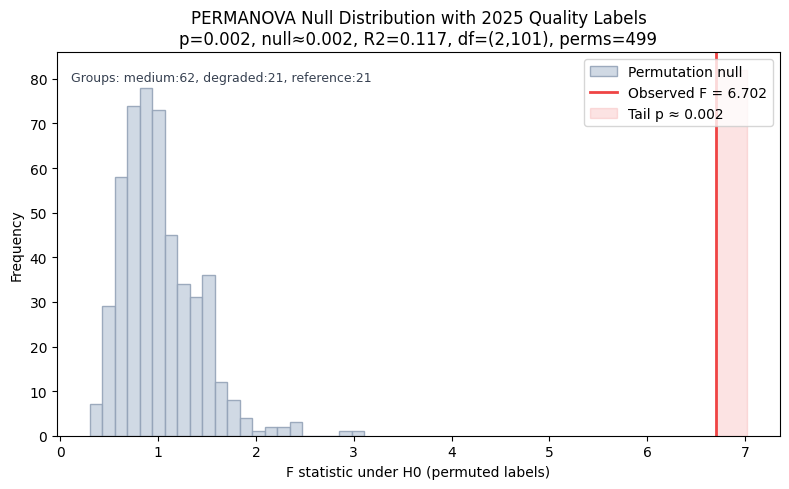

In [194]:
fig_f, ax_f, info_f = plot_permanova_null_distribution(X, 
                                                       labels,
                                                       permutations=499,
                                                       seed=2, 
                                                       title='PERMANOVA Null Distribution with 2025 Quality Labels')
# print(info_f)

## 3) Plot directional one-sided null
Use `plot_directional_null_distribution`. If you didn’t specify labels for reference/degraded, we infer them (e.g., 'reference' vs 'degraded' or 'bottom' vs 'top').

{'statistic': 0.6903480422893913, 'p_value': 0.002, 'p_tail': 0.002, 'mode': 'average', 'reference_label': 'reference', 'degraded_label': 'degraded', 'n_perm': 499, 'top_vars': ['%OC', 'Mn', 'Ni', 'Cd', 'Zn']}


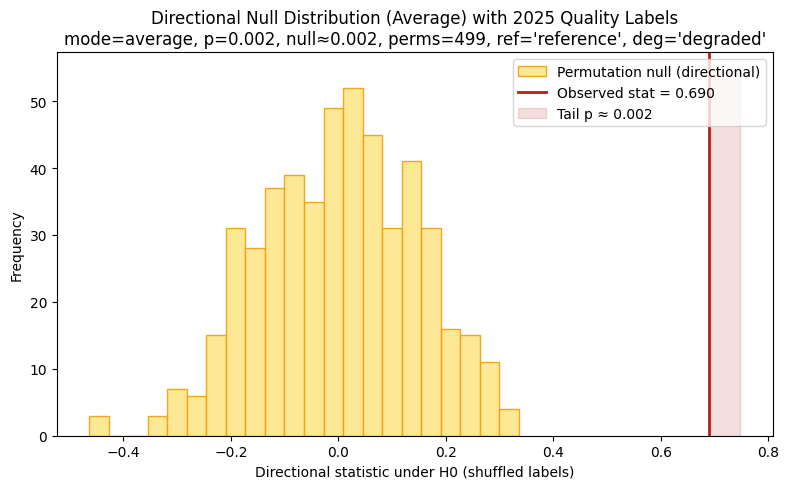

In [195]:
# Infer reference and degraded from labels when not provided
cats = list(pd.Categorical(labels).categories)
ref_candidates = [c for c in cats if str(c).lower().startswith('ref')]
deg_candidates = [c for c in cats if str(c).lower().startswith('deg')]
ref = ref_candidates[0] if ref_candidates else ('bottom' if 'bottom' in cats else min(cats))
deg = deg_candidates[0] if deg_candidates else ('top' if 'top' in cats else max(cats))
fig_d, ax_d, info_d = plot_directional_null_distribution(X,
                        labels,
                        ref,
                        deg,
                        mode='average',
                        permutations=499,
                        standardize=True,
                        var_names=var_names,
                        title = "Directional Null Distribution (Average) with 2025 Quality Labels")
print(info_d)